# Steel Image Classification with RNN's using LSTM
# Machine Learning Project

In [1]:
# importing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, LSTM, ConvLSTM1D, ConvLSTM2D
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## EDA

In [3]:
# checking for number of images in training
files = os.listdir('/Users/ali/Downloads/severstal-steel-defect-detection/train_images') 
number_files = len(files)

In [4]:
print('number of images in training:', number_files)

number of images in training: 12568


In [5]:
# creating dataframe that lists ImageId for training images
file_df = pd.DataFrame(files, columns = ['ImageId'])
file_df.head()

,ImageId
0,58ee62fd7.jpg
1,eeffa4c49.jpg
2,0dced41aa.jpg
3,bd2366c49.jpg
4,e2bdd4236.jpg


In [6]:
# checking for number of images that have defects in training from csv file
data = pd.read_csv("/Users/ali/Downloads/severstal-steel-defect-detection/train.csv")
print('number of images that have defects in training:', data.shape[0])

number of images that have defects in training: 7095


3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

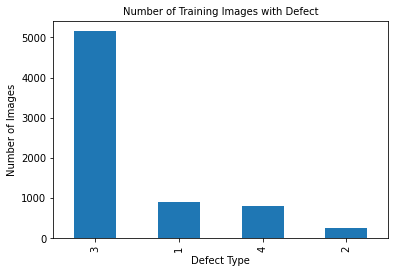

In [7]:
# Checking the classes of the images in training
data["ClassId"].value_counts().plot(kind = 'bar')
plt.title('Number of Training Images with Defect', fontsize=10)
plt.ylabel('Number of Images'); plt.xlabel('Defect Type')
data["ClassId"].value_counts()

## Feature Engineering & Transformation

In [8]:
data.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [9]:
# Creating dataframe that shows the multi-labels of classes classification of the images
data['values'] = 1
pivot = data[['ImageId','ClassId','values']].pivot(index='ImageId', columns='ClassId',values='values').reset_index()
file_df = file_df.merge(pivot, how='left', on='ImageId').fillna(0)
file_df.head()

,ImageId,1,2,3,4
0,58ee62fd7.jpg,0.0,0.0,1.0,0.0
1,eeffa4c49.jpg,1.0,0.0,1.0,0.0
2,0dced41aa.jpg,0.0,0.0,0.0,0.0
3,bd2366c49.jpg,0.0,0.0,0.0,0.0
4,e2bdd4236.jpg,0.0,0.0,1.0,0.0


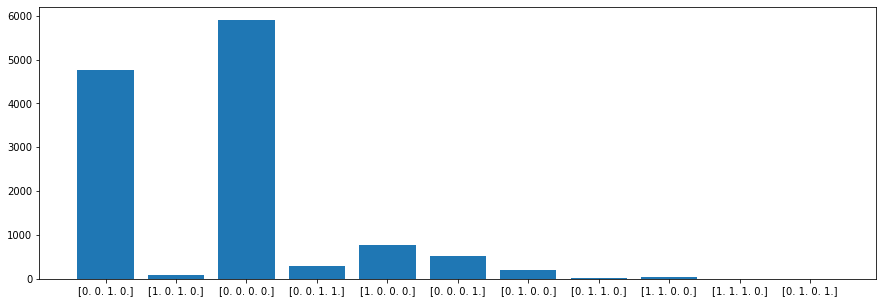

In [10]:
# Visualizing the imbalance of data
classes = file_df.iloc[:,1:5].to_numpy()
counts = Counter(str(l) for l in classes)
plt.figure(figsize=(15, 5))
plt.bar(*zip(*counts.items()))
plt.show()

In [11]:
# Porportion of Classes in the training image dataset
1/(data["ClassId"].value_counts()/len(file_df))

3     2.440388
1    14.011148
4    15.690387
2    50.882591
Name: ClassId, dtype: float64

In [12]:
# Spliting X_train, X_test, y_train and y_test 
X_train, X_test, y_train, y_test = train_test_split(file_df['ImageId'],file_df[[1,2,3,4]],test_size=0.3,random_state=1)

In [13]:
# Merging training and test datasets together to deal with class imbalance
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [14]:
train.head()

,ImageId,1,2,3,4
8191,9941cb9f1.jpg,0.0,0.0,1.0,0.0
974,16d9c0a30.jpg,0.0,0.0,0.0,0.0
5431,15f14781f.jpg,0.0,0.0,1.0,0.0
5707,3e3aa2898.jpg,0.0,0.0,0.0,0.0
3529,b0d290bbf.jpg,0.0,0.0,0.0,0.0


In [15]:
# Replicating rows of data according to class 
train['rpt'] = 1 + train[1]*2 + train[2]*8 + train[4]*2 + \
                   train[1]*train[2]*4 + train[1]*train[3]*4 + \
                   train[3]*train[4]*2 + train[2]*train[3]*8 + train[2]*train[4]*16
train = train.reindex(train.index.repeat(train.rpt)).reset_index(drop=True).drop(['rpt'],axis=1)
train.shape

(13543, 5)

In [16]:
# y_counts = train[[1,2,3,4]].to_numpy()

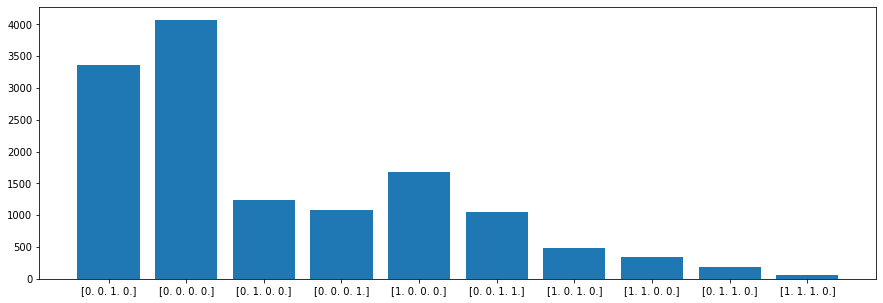

In [17]:
# Visualizing new class distribution of training dataset
y_counts_new = train[[1,2,3,4]].to_numpy()
counts = Counter(str(l) for l in y_counts_new)
plt.figure(figsize=(15, 5))
plt.bar(*zip(*counts.items()))
plt.show()

In [18]:
# Creating training dataset after transforming and replicating data due to class imbalance
X = []
y = [] 
for img,c1,c2,c3,c4 in tqdm(train.values):
    image=cv2.imread(f"/Users/ali/Downloads/severstal-steel-defect-detection/train_images/{img}",cv2.IMREAD_COLOR)
    image=cv2.resize(image,(71,71))
    X.append(image)
    y.append([c1,c2,c3,c4])
    
X = np.array(X)
y = np.array(y).astype(int)

100%|██████████| 13543/13543 [01:06<00:00, 203.56it/s]


In [19]:
# Creating test dataset
X_t = []
y_t = [] 
for img,c1,c2,c3,c4 in tqdm(test.values):
    image=cv2.imread(f"/Users/ali/Downloads/severstal-steel-defect-detection/train_images/{img}",cv2.IMREAD_COLOR)
    image=cv2.resize(image,(71,71))
    X_t.append(image)
    y_t.append([c1,c2,c3,c4])

X_t = np.array(X_t)
y_t = np.array(y_t).astype(int)

100%|██████████| 3771/3771 [00:18<00:00, 199.70it/s]


## Building out our RNN Models

In [20]:
X.shape

(13543, 71, 71, 3)

In [21]:
y.shape

(13543, 4)

In [22]:
X_rnn = X.reshape((13543, 5041, 3))

### Base RNN Model

In [23]:
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN

In [24]:
base_rnn = Sequential()
base_rnn.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (5041, 3)))
base_rnn.add(Dense(units = 4, activation = "relu"))
base_rnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',  
              metrics = ['accuracy'])

base_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1152      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 1,284
Trainable params: 1,284
Non-trainable params: 0
_________________________________________________________________


In [25]:
base_rnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy","binary_accuracy"])

In [26]:
%%time 

history_1 = base_rnn.fit(X_rnn, y,
                       validation_split = 0.25, 
                       epochs = 12, ## Change
                       batch_size = 128);

Epoch 1/12
80/80 [==============================] - 67s 825ms/step - loss: 5.2367 - accuracy: 0.1064 - binary_accuracy: 0.6424 - val_loss: 5.2321 - val_accuracy: 0.0936 - val_binary_accuracy: 0.6395
Epoch 2/12
80/80 [==============================] - 67s 831ms/step - loss: 5.8651 - accuracy: 0.2452 - binary_accuracy: 0.5933 - val_loss: 6.0539 - val_accuracy: 0.3213 - val_binary_accuracy: 0.5819
Epoch 3/12
80/80 [==============================] - 112s 1s/step - loss: 5.6662 - accuracy: 0.2006 - binary_accuracy: 0.6083 - val_loss: 5.7552 - val_accuracy: 0.1214 - val_binary_accuracy: 0.6017
Epoch 4/12
80/80 [==============================] - 66s 830ms/step - loss: 5.6335 - accuracy: 0.1371 - binary_accuracy: 0.6135 - val_loss: 5.7803 - val_accuracy: 0.3204 - val_binary_accuracy: 0.6037
Epoch 5/12
80/80 [==============================] - 363s 5s/step - loss: 4.2269 - accuracy: 0.3178 - binary_accuracy: 0.7088 - val_loss: 4.0342 - val_accuracy: 0.3281 - val_binary_accuracy: 0.7214
Epoch 6/1

In [27]:
X_t.shape

(3771, 71, 71, 3)

In [28]:
X_t_rnn = X_t.reshape(3771, 5041, 3)

In [29]:
base_rnn.evaluate(X_t_rnn, y_t, batch_size = 128)

30/30 [==============================] - 4s 144ms/step - loss: 2.5961 - accuracy: 0.4025 - binary_accuracy: 0.8166


[2.5961055755615234, 0.4025457501411438, 0.8165605664253235]

In [30]:
y_pred = base_rnn.predict(X_t_rnn)

In [31]:
df_0 = pd.DataFrame(y_pred, columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4'])

In [32]:
affected = (df_0 != 0).any(axis=1)
nz = df_0[affected]
df_0[affected] = (nz.T == nz.max(axis=1)).T.astype(int)

In [34]:
y_pred = y_pred.astype(int)
df_test_1 = pd.DataFrame(y_t, columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4'])

In [35]:
df_0.head()

,Class_1,Class_2,Class_3,Class_4
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


#### Base RNN Model: Class 1 Evaluation metrics

In [36]:
print('Precision for class 1: %.3f' % precision_score(df_test_1['Class_1'], df_0['Class_1']))

Precision for class 1: 0.167


In [37]:
print('Recall for class 1: %.3f' % recall_score(df_test_1['Class_1'], df_0['Class_1']))

Recall for class 1: 0.037


In [38]:
print('F1 Score: %.3f for class 1' % f1_score(df_test_1['Class_1'], df_0['Class_1']))

F1 Score: 0.061 for class 1


#### Base RNN Model: Class 2 Evaluation metrics

In [41]:
print('Precision for class 2: %.3f' % precision_score(df_test_1['Class_2'], df_0['Class_2']))

Precision for class 2: 0.000


/Users/ali/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print('Recall for class 2: %.3f' % recall_score(df_test_1['Class_2'], df_0['Class_2']))

Recall for class 2: 0.000


In [43]:
print('F1 Score for class 2: %.3f' % f1_score(df_test_1['Class_2'], df_0['Class_2']))

F1 Score for class 2: 0.000


#### Base RNN Model: Class 3 Evaluation metrics

In [44]:
print('Precision for class 3: %.3f' % precision_score(df_test_1['Class_3'], df_0['Class_3']))

Precision for class 3: 0.402


In [45]:
print('Precision for class 3: %.3f' % recall_score(df_test_1['Class_3'], df_0['Class_3']))

Precision for class 3: 0.975


In [46]:
print('Precision for class 3: %.3f' % f1_score(df_test_1['Class_3'], df_0['Class_3']))

Precision for class 3: 0.569


#### Base RNN Model: Class 4 Evaluation metrics

In [47]:
print('Precision for class 4: %.3f' % precision_score(df_test_1['Class_4'], df_0['Class_4']))

Precision for class 4: 0.133


In [48]:
print('Precision for class 4: %.3f' % recall_score(df_test_1['Class_4'], df_0['Class_4']))

Precision for class 4: 0.009


In [49]:
print('Precision for class 4: %.3f' % f1_score(df_test_1['Class_4'], df_0['Class_4']))

Precision for class 4: 0.016


#### Further Model Evaluation

In [50]:
history_df = pd.DataFrame(history_1.history)
history_df.index += 1
history_df.head()

,loss,accuracy,binary_accuracy,val_loss,val_accuracy,val_binary_accuracy
1,5.236731,0.106429,0.642365,5.232104,0.093621,0.639471
2,5.865085,0.245151,0.593261,6.053938,0.321323,0.581881
3,5.666201,0.200551,0.608250,5.755183,0.121382,0.601742
4,5.633504,0.137147,0.613493,5.780274,0.320437,0.603736
5,4.226892,0.317810,0.708797,4.034151,0.328116,0.721426


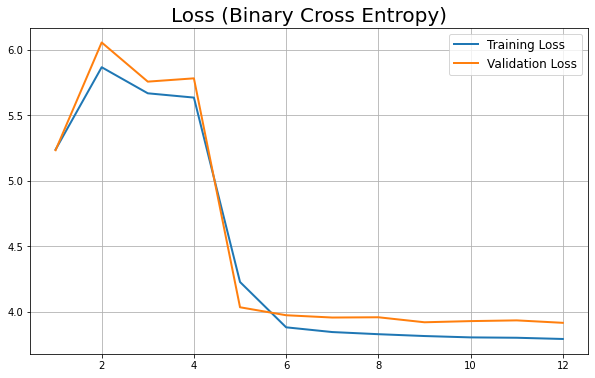

In [51]:
plt.subplots(figsize=(10,6))
plt.plot(history_df.loc[:, ['loss','val_loss']], lw = 2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize = 12, loc=1)
plt.grid()
plt.show()

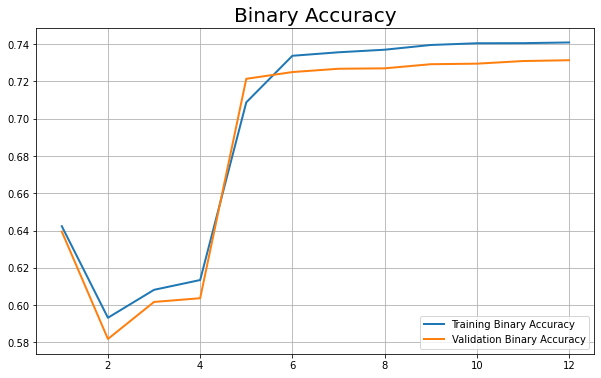

In [52]:
plt.subplots(figsize=(10,6))
plt.plot(history_df.loc[:, ['binary_accuracy','val_binary_accuracy']], lw = 2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize = 10, loc=4)
plt.grid()
plt.show()

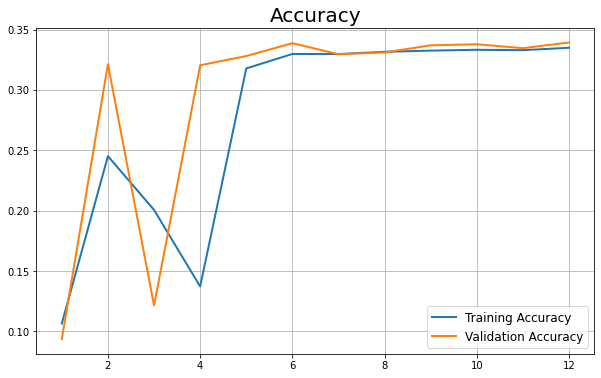

In [53]:
plt.subplots(figsize=(10,6))
plt.plot(history_df.loc[:, ['accuracy','val_accuracy']], lw = 2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=12, loc=4)
plt.grid()
plt.show()

### RNN Model using standard parameters

In [54]:
model = Sequential()
model.add(LSTM(1, input_shape = (5041, 3), return_sequences = True))
model.add(Dense(units = 4, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(52,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(52,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4,activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5041, 1)           20        
                                                                 
 dense_1 (Dense)             (None, 5041, 4)           8         
                                                                 
 dense_2 (Dense)             (None, 5041, 128)         640       
                                                                 
 dropout (Dropout)           (None, 5041, 128)         0         
                                                                 
 flatten (Flatten)           (None, 645248)            0         
                                                                 
 dense_3 (Dense)             (None, 52)                33552948  
                                                                 
 dropout_1 (Dropout)         (None, 52)               

In [55]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy","binary_accuracy"])

In [56]:
early_stopping = EarlyStopping()

In [57]:
history_2 = model.fit(X_rnn, y,
                      validation_split = 0.25, 
                      epochs = 12, # Change
                      batch_size = 128
                      ); 

Epoch 1/12
80/80 [==============================] - 142s 2s/step - loss: 0.5688 - accuracy: 0.3476 - binary_accuracy: 0.7373 - val_loss: 0.4667 - val_accuracy: 0.3630 - val_binary_accuracy: 0.7871
Epoch 2/12
80/80 [==============================] - 140s 2s/step - loss: 0.5055 - accuracy: 0.3530 - binary_accuracy: 0.7715 - val_loss: 0.4533 - val_accuracy: 0.3698 - val_binary_accuracy: 0.7871
Epoch 3/12
80/80 [==============================] - 141s 2s/step - loss: 0.4806 - accuracy: 0.3659 - binary_accuracy: 0.7768 - val_loss: 0.4387 - val_accuracy: 0.3928 - val_binary_accuracy: 0.7871
Epoch 4/12
80/80 [==============================] - 140s 2s/step - loss: 0.4654 - accuracy: 0.3784 - binary_accuracy: 0.7793 - val_loss: 0.4278 - val_accuracy: 0.3907 - val_binary_accuracy: 0.7934
Epoch 5/12
80/80 [==============================] - 140s 2s/step - loss: 0.4534 - accuracy: 0.3928 - binary_accuracy: 0.7844 - val_loss: 0.4208 - val_accuracy: 0.4309 - val_binary_accuracy: 0.7936
Epoch 6/12
80/8

In [58]:
model.evaluate(X_t_rnn, y_t, batch_size = 128)

30/30 [==============================] - 8s 268ms/step - loss: 0.3219 - accuracy: 0.4346 - binary_accuracy: 0.8713


[0.32187962532043457, 0.43463271856307983, 0.8713206052780151]

In [59]:
y_pred = model.predict(X_t_rnn)

In [60]:
df = pd.DataFrame(y_pred, columns = ['Class_1','Class_2','Class_3', 'Class_4'])

In [61]:
affected = (df != 0).any(axis=1)
nz = df[affected]
df[affected] = (nz.T == nz.max(axis=1)).T.astype(int)

In [63]:
y_pred = y_pred.astype(int)
df_test_1 = pd.DataFrame(y_t, columns = ['Class_1','Class_2','Class_3', 'Class_4'])

In [64]:
df.head()

,Class_1,Class_2,Class_3,Class_4
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


#### RNN Model 2: Class 1 Evaluation metrics

In [65]:
print('Precision for class 1: %.3f' % precision_score(df_test_1['Class_1'], df['Class_1']))

Precision for class 1: 0.432


In [66]:
print('Recall for class 1: %.3f' % recall_score(df_test_1['Class_1'], df['Class_1']))

Recall for class 1: 0.329


In [67]:
print('F1 Score: %.3f for class 1' % f1_score(df_test_1['Class_1'], df['Class_1']))

F1 Score: 0.374 for class 1


#### RNN Model 2: Class 2 Evaluation metrics

In [68]:
print('Precision for class 2: %.3f' % precision_score(df_test_1['Class_2'], df['Class_2']))

Precision for class 2: 0.330


In [69]:
print('Precision for class 2: %.3f' % recall_score(df_test_1['Class_2'], df['Class_2']))

Precision for class 2: 0.863


In [70]:
print('Precision for class 2: %.3f' % f1_score(df_test_1['Class_2'], df['Class_2']))

Precision for class 2: 0.477


#### RNN Model 2: Class 3 Evaluation metrics

In [71]:
print('Precision for class 3: %.3f' % precision_score(df_test_1['Class_3'], df['Class_3']))

Precision for class 3: 0.425


In [72]:
print('Precision for class 3: %.3f' % recall_score(df_test_1['Class_3'], df['Class_3']))

Precision for class 3: 0.959


In [73]:
print('Precision for class 3: %.3f' % f1_score(df_test_1['Class_3'], df['Class_3']))

Precision for class 3: 0.589


#### RNN Model 2: Class 4 Evaluation metrics

In [74]:
print('Precision for class 4: %.3f' % precision_score(df_test_1['Class_4'], df['Class_4']))

Precision for class 4: 0.000


/Users/ali/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print('Precision for class 4: %.3f' % recall_score(df_test_1['Class_4'], df['Class_4']))

Precision for class 4: 0.000


In [76]:
print('Precision for class 4: %.3f' % f1_score(df_test_1['Class_4'], df['Class_4']))

Precision for class 4: 0.000


#### Further Model Evaluation

In [77]:
history_df_1 = pd.DataFrame(history_2.history)
history_df_1.index += 1
history_df_1.head()

,loss,accuracy,binary_accuracy,val_loss,val_accuracy,val_binary_accuracy
1,0.568831,0.347642,0.737299,0.466737,0.362965,0.787138
2,0.505519,0.352959,0.771537,0.453308,0.369758,0.787138
3,0.480582,0.365856,0.776804,0.438727,0.392794,0.787138
4,0.465388,0.378360,0.779266,0.427841,0.390727,0.793414
5,0.453399,0.392833,0.784434,0.420798,0.430892,0.793636


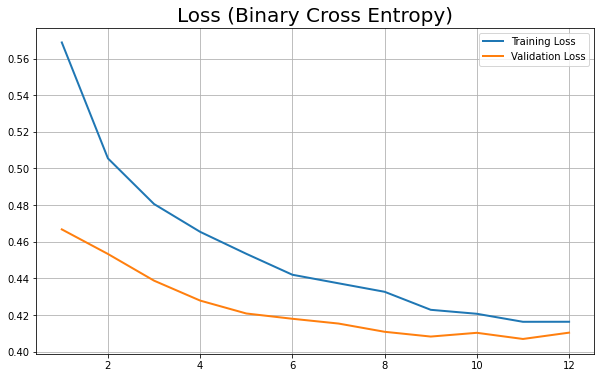

In [78]:
plt.subplots(figsize=(10,6))
plt.plot(history_df_1.loc[:, ['loss','val_loss']], lw = 2)
plt.title('Loss (Binary Cross Entropy)', fontsize=20)
plt.legend(['Training Loss','Validation Loss'], fontsize = 10, loc=1)
plt.grid()
plt.show()

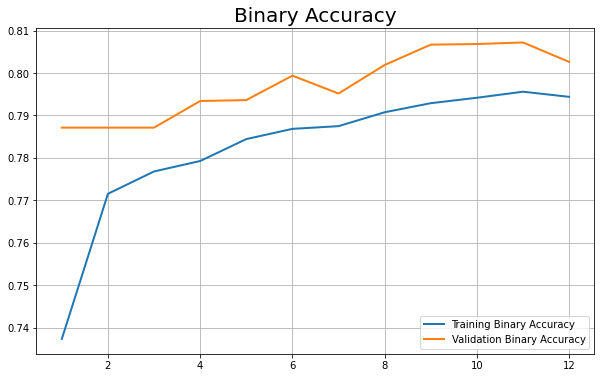

In [79]:
plt.subplots(figsize=(10,6))
plt.plot(history_df_1.loc[:, ['binary_accuracy','val_binary_accuracy']], lw = 2)
plt.title('Binary Accuracy', fontsize=20)
plt.legend(['Training Binary Accuracy','Validation Binary Accuracy'], fontsize = 10, loc=4)
plt.grid()
plt.show()

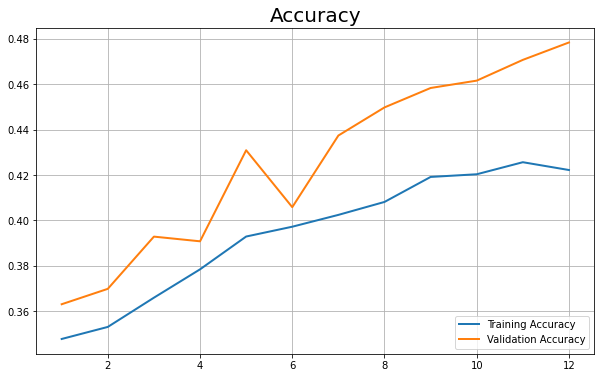

In [80]:
plt.subplots(figsize=(10,6))
plt.plot(history_df_1.loc[:, ['accuracy','val_accuracy']], lw=2)
plt.title('Accuracy', fontsize=20)
plt.legend(['Training Accuracy','Validation Accuracy'], fontsize=10, loc=4)
plt.grid()
plt.show()